## NLP Analysis Workflow with LDA and Sentiment

### Setup and Installation
1. **Install Required Libraries**  
   Installs essential libraries for data handling, NLP, and visualization.

---

### Import Libraries and Setup
2. **Import Python Libraries**  
   Loads `pandas`, `numpy`, `matplotlib`, `seaborn`, `TextBlob`, `wordcloud`, `scikit-learn`, `nltk`, etc.

3. **Download NLTK Resources**  
   Downloads `punkt` and `stopwords` from NLTK for tokenization and filtering.

4. **Suppress Warnings and Configure Display**  
   Suppresses warnings and sets up `IPython.display` for better visualization.

---

### Load and Prepare Data
5. **Load Dataset**  
   Loads the conversational apps review dataset from a CSV file.

6. **Text Preprocessing**  
   - Converts text to lowercase  
   - Removes punctuation  
   - Tokenizes text and removes English stopwords  
   - Joins the cleaned tokens into one string per review  
   - Saves result in a new column `clean_text`

7. **Remove Empty Cleaned Texts**  
   Filters out rows with empty `clean_text` after preprocessing.

---

### Topic Modeling with LDA
8. **Vectorize Text**  
   Applies `CountVectorizer` to convert text into a document-term matrix, excluding rare and overly common terms.

9. **Apply LDA Model**  
   - Uses Latent Dirichlet Allocation (LDA) to discover 6 latent topics  
   - Assigns the dominant topic to each review  
   - Stores result in the `topic` column

10. **Map Topics to Descriptive Labels**  
    Creates human-readable topic labels based on keyword inspection:
    - 0 → Repetitive & Generic Responses  
    - 1 → Cost & Payment Issues  
    - 2 → Unhelpful & Nonsensical Advice  
    - 3 → Subscription & Pricing Problems  
    - 4 → App Updates & Changes  
    - 5 → Positive & Helpful Experiences  
    Adds new column `topic_label`.

---

### Sentiment Analysis
11. **Compute Sentiment Polarity**  
    - Uses `TextBlob` to calculate polarity scores for each review  
    - Adds sentiment score to the `sentiment` column

---

### Visualizations and Interpretation
12. **Plot 1: Count per Topic**  
    - Displays a bar chart showing the number of reviews per topic  
    - Interpretation: Highlights the most frequent issues users report

13. **Plot 2: Sentiment per Topic**  
    - Displays a boxplot of sentiment scores for each topic  
    - Interpretation: Shows which topics users feel negatively or positively about

14. **Plot 3: Word Cloud per Topic**  
    - Generates a word cloud for each topic  
    - Interpretation: Reveals dominant terms associated with each topic

---


In [7]:
# Imports (must come first to avoid E402)
# %pip install seaborn --quiet
# %pip install textblob
import warnings
import re
import nltk
import os
from textblob import TextBlob
from nltk.corpus import stopwords
from IPython.display import display, HTML  # <-- fixed
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK data
nltk.download("punkt")
nltk.download("stopwords")

# Suppress warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\azizt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\azizt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Repo root detected at: c:\Users\azizt\OneDrive\Desktop\ET6-CDSP-group-20-repo
Loaded 20178 reviews for Conversational Apps.
Successfully cleaned 20178 documents for modeling.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\azizt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\azizt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


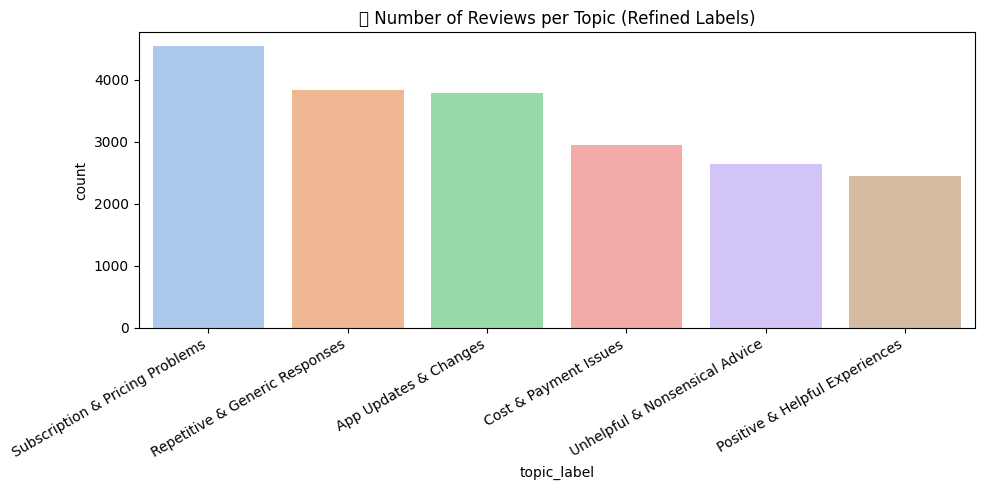

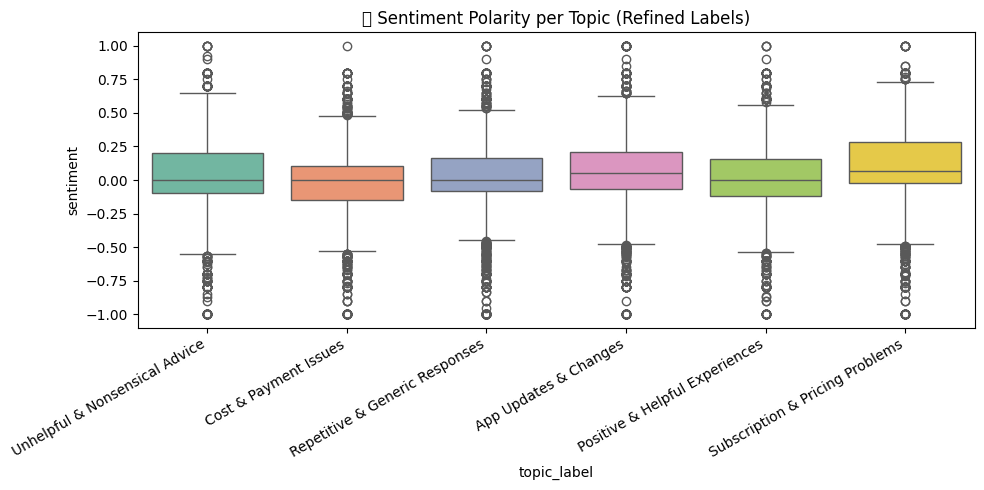

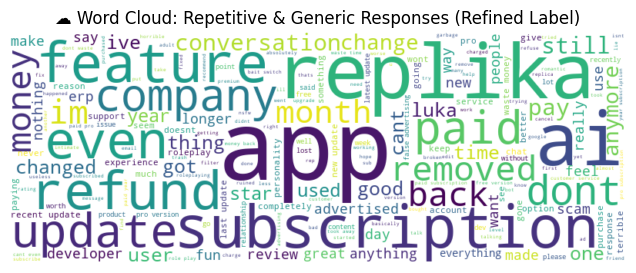

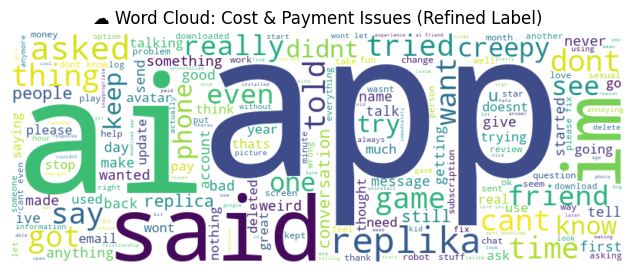

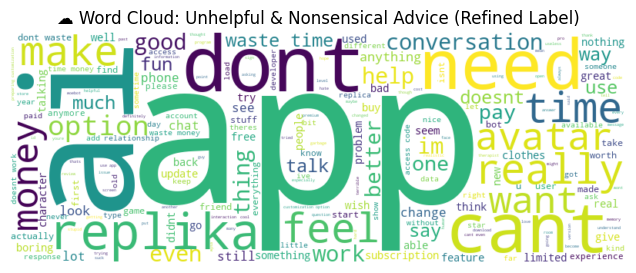

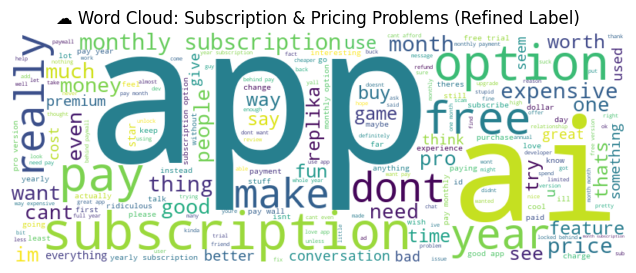

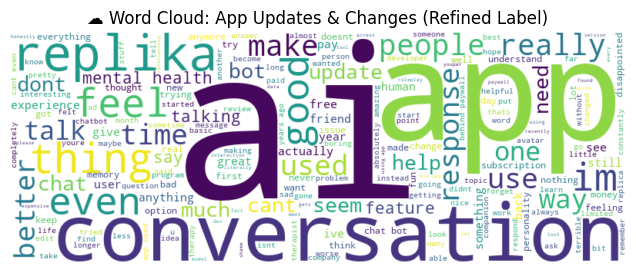

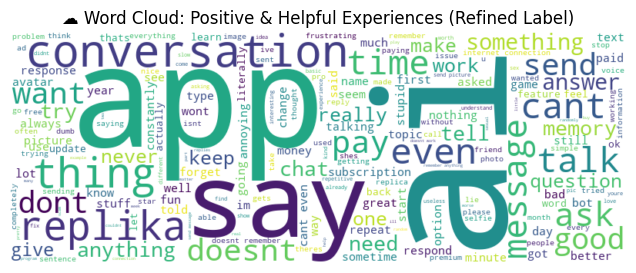

In [8]:
# Load data
# --- DETECT REPO ROOT ---
cwd = os.getcwd()
while not os.path.exists(os.path.join(cwd, "1_datasets")):
    parent = os.path.dirname(cwd)
    if parent == cwd:
        raise FileNotFoundError("Could not find repo root containing '1_datasets'.")
    cwd = parent

REPO_ROOT = cwd
print(f"Repo root detected at: {REPO_ROOT}")

# --- BUILD PATH TO CONVERSATIONAL CSV ---
DATA_PATH = os.path.join(
    REPO_ROOT, "1_datasets", "all_datasets", "conversational_apps_themed_and_scored.csv"
)
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"File not found: {DATA_PATH}")

# --- LOAD CSV ---
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df)} reviews for Conversational Apps.")

# --- CLEAN DATA ---
df.dropna(subset=["review_text"], inplace=True)
df["review_text"] = df["review_text"].astype(str).str.lower().str.strip()
df = df[df["review_text"].str.len() > 15]

# --- CONVERT TO LIST OF DOCUMENTS ---
docs = df["review_text"].tolist()
print(f"Successfully cleaned {len(docs)} documents for modeling.")

# --- DOWNLOAD NLTK DATA ---
nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


# --- PREPROCESS TEXT ---
def preprocess_text(text):
    text = re.sub(r"[^\w\s]", "", str(text))
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)


df["clean_text"] = df["review_text"].apply(preprocess_text)
df = df[df["clean_text"].str.strip() != ""]

# --- VECTORIZE TEXT ---
vectorizer = CountVectorizer(stop_words="english", max_df=0.9, min_df=10)
X = vectorizer.fit_transform(df["clean_text"])
feature_names = vectorizer.get_feature_names_out()

# --- APPLY LDA ---
n_topics = 6
lda = LDA(n_components=n_topics, random_state=42)
lda.fit(X)
topic_assignments = lda.transform(X).argmax(axis=1)
df["topic"] = topic_assignments

# --- REFINED TOPIC LABELS ---
topic_labels = {
    0: "Repetitive & Generic Responses",
    1: "Cost & Payment Issues",
    2: "Unhelpful & Nonsensical Advice",
    3: "Subscription & Pricing Problems",
    4: "App Updates & Changes",
    5: "Positive & Helpful Experiences",
}
df["topic_label"] = df["topic"].map(topic_labels)


# --- SENTIMENT ANALYSIS ---
def get_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except Exception:
        return 0


df["sentiment"] = df["clean_text"].apply(get_sentiment)

# --- PLOTS ---
plt.figure(figsize=(10, 5))
sns.countplot(
    data=df,
    x="topic_label",
    order=df["topic_label"].value_counts().index,
    palette="pastel",
)
plt.xticks(rotation=30, ha="right")
plt.title("🔍 Number of Reviews per Topic (Refined Labels)")
plt.tight_layout()
plt.show()
display(
    HTML(
        "<b>Interpretation:</b> This plot shows which failure themes are most common across user complaints based on refined labels."
    )
)

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="topic_label", y="sentiment", palette="Set2")
plt.xticks(rotation=30, ha="right")
plt.title("💬 Sentiment Polarity per Topic (Refined Labels)")
plt.tight_layout()
plt.show()
display(
    HTML(
        "<b>Interpretation:</b> This plot shows how negative or neutral users feel about each failure category based on refined labels."
    )
)

for topic_num in range(n_topics):
    label = topic_labels[topic_num]
    topic_docs = df[df["topic"] == topic_num]["clean_text"]
    text = " ".join(topic_docs)
    if text.strip() == "":
        continue
    wordcloud = WordCloud(width=800, height=300, background_color="white").generate(
        text
    )
    plt.figure(figsize=(10, 3))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"☁️ Word Cloud: {label} (Refined Label)")
    plt.show()
    display(
        HTML(
            f"<b>Interpretation:</b> The word cloud for '{label}' highlights the most frequent terms associated with this topic."
        )
    )

## Understanding User Experiences with Mental Health Chatbots


The most significant challenges users face, appearing frequently in feedback, center around conversational quality:

*   **Unhelpful & Nonsensical Advice (Topic 2):** Many users reported receiving responses that felt irrelevant, inappropriate, or simply didn't address their needs. This suggests the chatbots struggle to truly grasp the context and emotional depth of user input, falling short of providing meaningful support.

*   **Repetitive & Generic Responses (Topic 0):** A common complaint was the feeling of interacting with an automated system due to repetitive and unoriginal replies. This lack of personalization makes conversations feel less engaging and highlights the difficulty in creating dynamic, human-like dialogue.

While these conversational failures are notable and point to areas needing significant improvement, it's also crucial to acknowledge the positive impact these tools have. The analysis showed that **Positive & Helpful Experiences (Topic 5)** was the most frequently discussed theme. This indicates that, for many users, these chatbots are indeed providing valuable interactions and contributing positively to their well-being.

These findings collectively illustrate the current state of mental health chatbots: they offer promise and deliver positive experiences for some, yet they still grapple with fundamental challenges in natural language understanding and generating truly empathetic and contextually appropriate responses. Bridging this gap is essential for these tools to reach their full potential in providing effective emotional support.

**Acknowledging Potential Interpretations:**

It's worth noting that our interpretation of the themes, particularly the assignment of descriptive labels to the topics identified by the model, involved a degree of subjective judgment based on the most frequent words within each topic. Different perspectives might lead to slightly varied descriptions of these themes.